# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 26.09.2021

Мягкий дедлайн: 23:59MSK 11.10.2021

Жесткий дедлайн: 23:59MSK 14.10.2021

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
!pip install folium

In [2]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar
from matplotlib.pyplot import figure
%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [5]:
train['Date'] = pd.to_datetime(train['pickup_datetime']).dt.date
train['Time'] = pd.to_datetime(train['pickup_datetime']).dt.time

In [6]:
train = train.drop('dropoff_datetime', axis = 1)

In [7]:
train.sample()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Date,Time
1347643,id2539304,2,2016-06-16 07:58:02,2,-73.990509,40.742329,-73.991028,40.738178,N,249,2016-06-16,07:58:02


В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

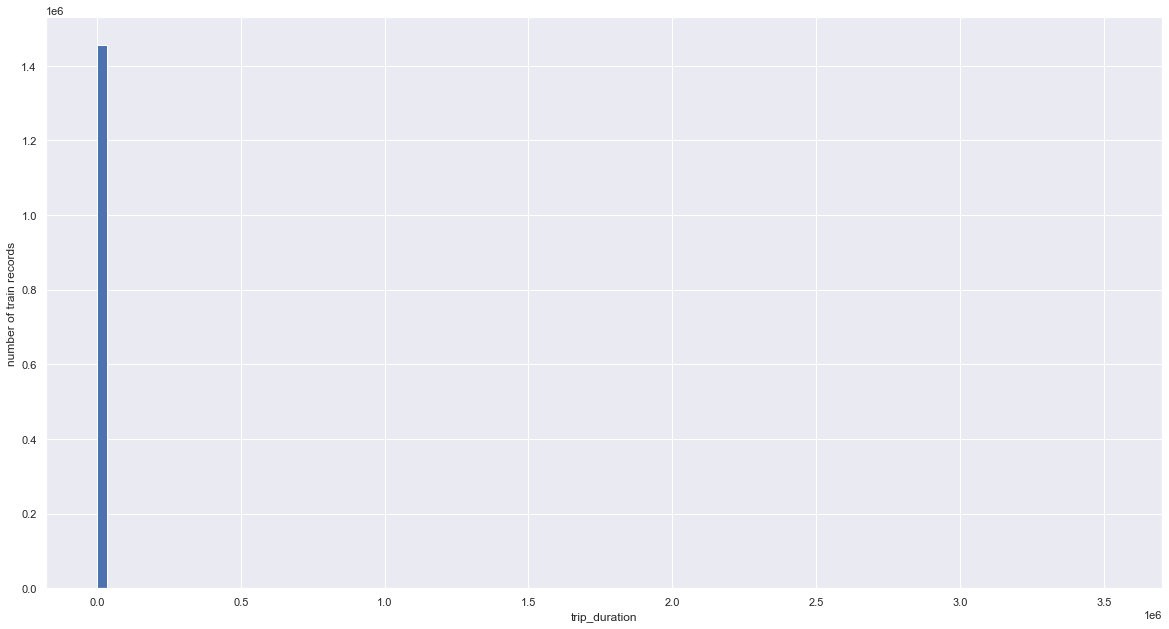

In [8]:
plt.hist(train['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
fig = plt.gcf()
fig.set_size_inches(20, 10.5)
plt.show()
# https://github.com/esokolov/ml-course-hse/blob/master/2021-fall/seminars/sem01-pandas.ipynb
# На больших данных не информативно использовать 

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

Тут есть выбросы, где есть большие по времени поездки. Все поездки больше > 10 тыс сек -> это скорей всего есть выбросы. Но сама по себе гистограмма не информативна, нужно посмотреть логарифм этих поездок в секундах. 

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

Тут присутствуют большие значения. MSLE - используется для неотрицательных значений ( тут у нас нет отрицательных значений ). Еще MSLE штрафует заниженные прогнозы сильнее чем завышенные. 

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: Просто подставим вместо $y_i = \exp(\hat{y}_i) - 1.$
Такую же опрерацию проведем и с $a_i =  \exp(\hat{a}(x_i)) - 1.$ 
Так как монотонности схожи и есть совпадение в минимуме - все окей. Тогда нули обнуляться за счет того, что мы вычтем единицы. Получим $\sqrt{\frac{1}{\ell}\sum\limits_{i=1}^{\ell} \big(\hat{y}_i - \hat{a}(x_i)\big)^2} = RMSE(X, \hat{y}, \hat{a})$
Так как RMSE это всего лишь корень от MSE, то в связи с тем, что корень не меняет функцию, оставляя её такой же монотонной и непрерывной - а только уменьшает его значение за счет извлечения корня. 

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [9]:
train['log1p_trip_duration'] = np.log1p(train.trip_duration)

/Users/alexanderskovorodko/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


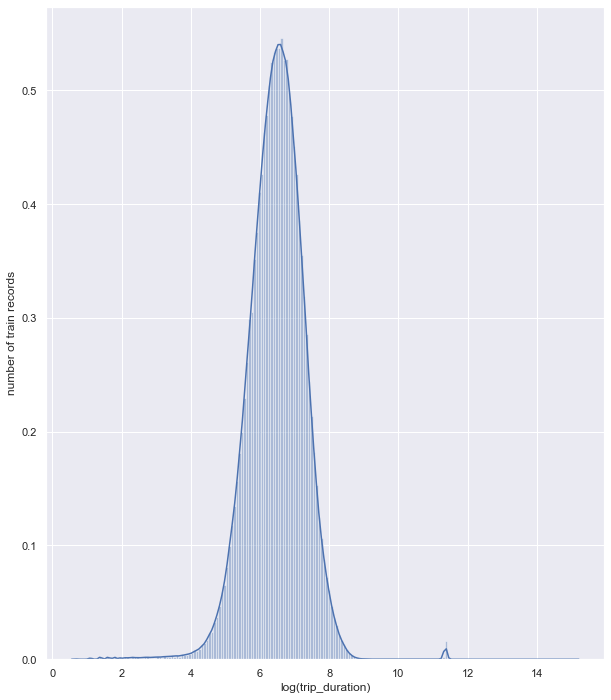

In [10]:
plt.figure(figsize=(10, 12))
sns.distplot(train['log1p_trip_duration'].values, bins=200)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

In [11]:
duration_minut = train['trip_duration'] / 60
duration_minut.max()

58771.36666666667

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

Так как было доказано выше, что RMSLE для модели  𝑎  эквивалентна оптимизации MSE для модели  𝑎̂  -> воспользуемся MSE ( ну мы точно её проходили и вроде как умеем использовать ( а мб и нет ) 

In [12]:
log_trip_dur = train['log1p_trip_duration']

In [13]:
from sklearn.model_selection import train_test_split

y = train["trip_duration"]
X = train.drop(columns=["trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(train, log_trip_dur, test_size=0.3, random_state=10)

In [14]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)

In [15]:
y_pred_mean_const = y_train.mean()

In [16]:
print(y_pred_mean_const)

6.46664647890804


Поскольку RMSE является внешним критерием качества - то надо найти его на тест. выборке. - > Введем массив (название) в виде константного предсказания как среднее по train, для test 

In [17]:
y_test.shape

(437594,)

In [18]:
predict_mean_test = np.array([y_pred_mean_const]*y_test.shape[0])

In [19]:
print('MSE of const. predicton calcul as mean on y_train: ',mean_squared_error(y_test,predict_mean_test))

MSE of const. predicton calcul as mean on y_train:  0.6308948678400609


In [20]:
train['Date'] = pd.to_datetime(train['Date'])

## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [21]:
# Часть 1. Изучаем pickup_datetime  
daily_trips = train.Date.value_counts().to_frame()
daily_trips = daily_trips.rename(columns = {'Date':'Sec'})
daily_trips = daily_trips.reset_index()
daily_trips = daily_trips.rename(columns = {'index':'Date'})
daily_trips

,Date,Sec
0,2016-04-09,9796
1,2016-04-16,9602
2,2016-03-05,9597
3,2016-04-02,9325
4,2016-02-13,9309
...,...,...
177,2016-01-03,6353
178,2016-01-25,6084
179,2016-05-30,5570
180,2016-01-24,3383


In [22]:
train = train.sort_values(by = 'Date')

In [23]:
train['Date'] = pd.to_datetime(train['Date'])

In [24]:
train.dtypes

id                             object
vendor_id                       int64
pickup_datetime                object
passenger_count                 int64
pickup_longitude              float64
pickup_latitude               float64
dropoff_longitude             float64
dropoff_latitude              float64
store_and_fwd_flag             object
trip_duration                   int64
Date                   datetime64[ns]
Time                           object
log1p_trip_duration           float64
dtype: object

Text(0, 0.5, 'Sec')

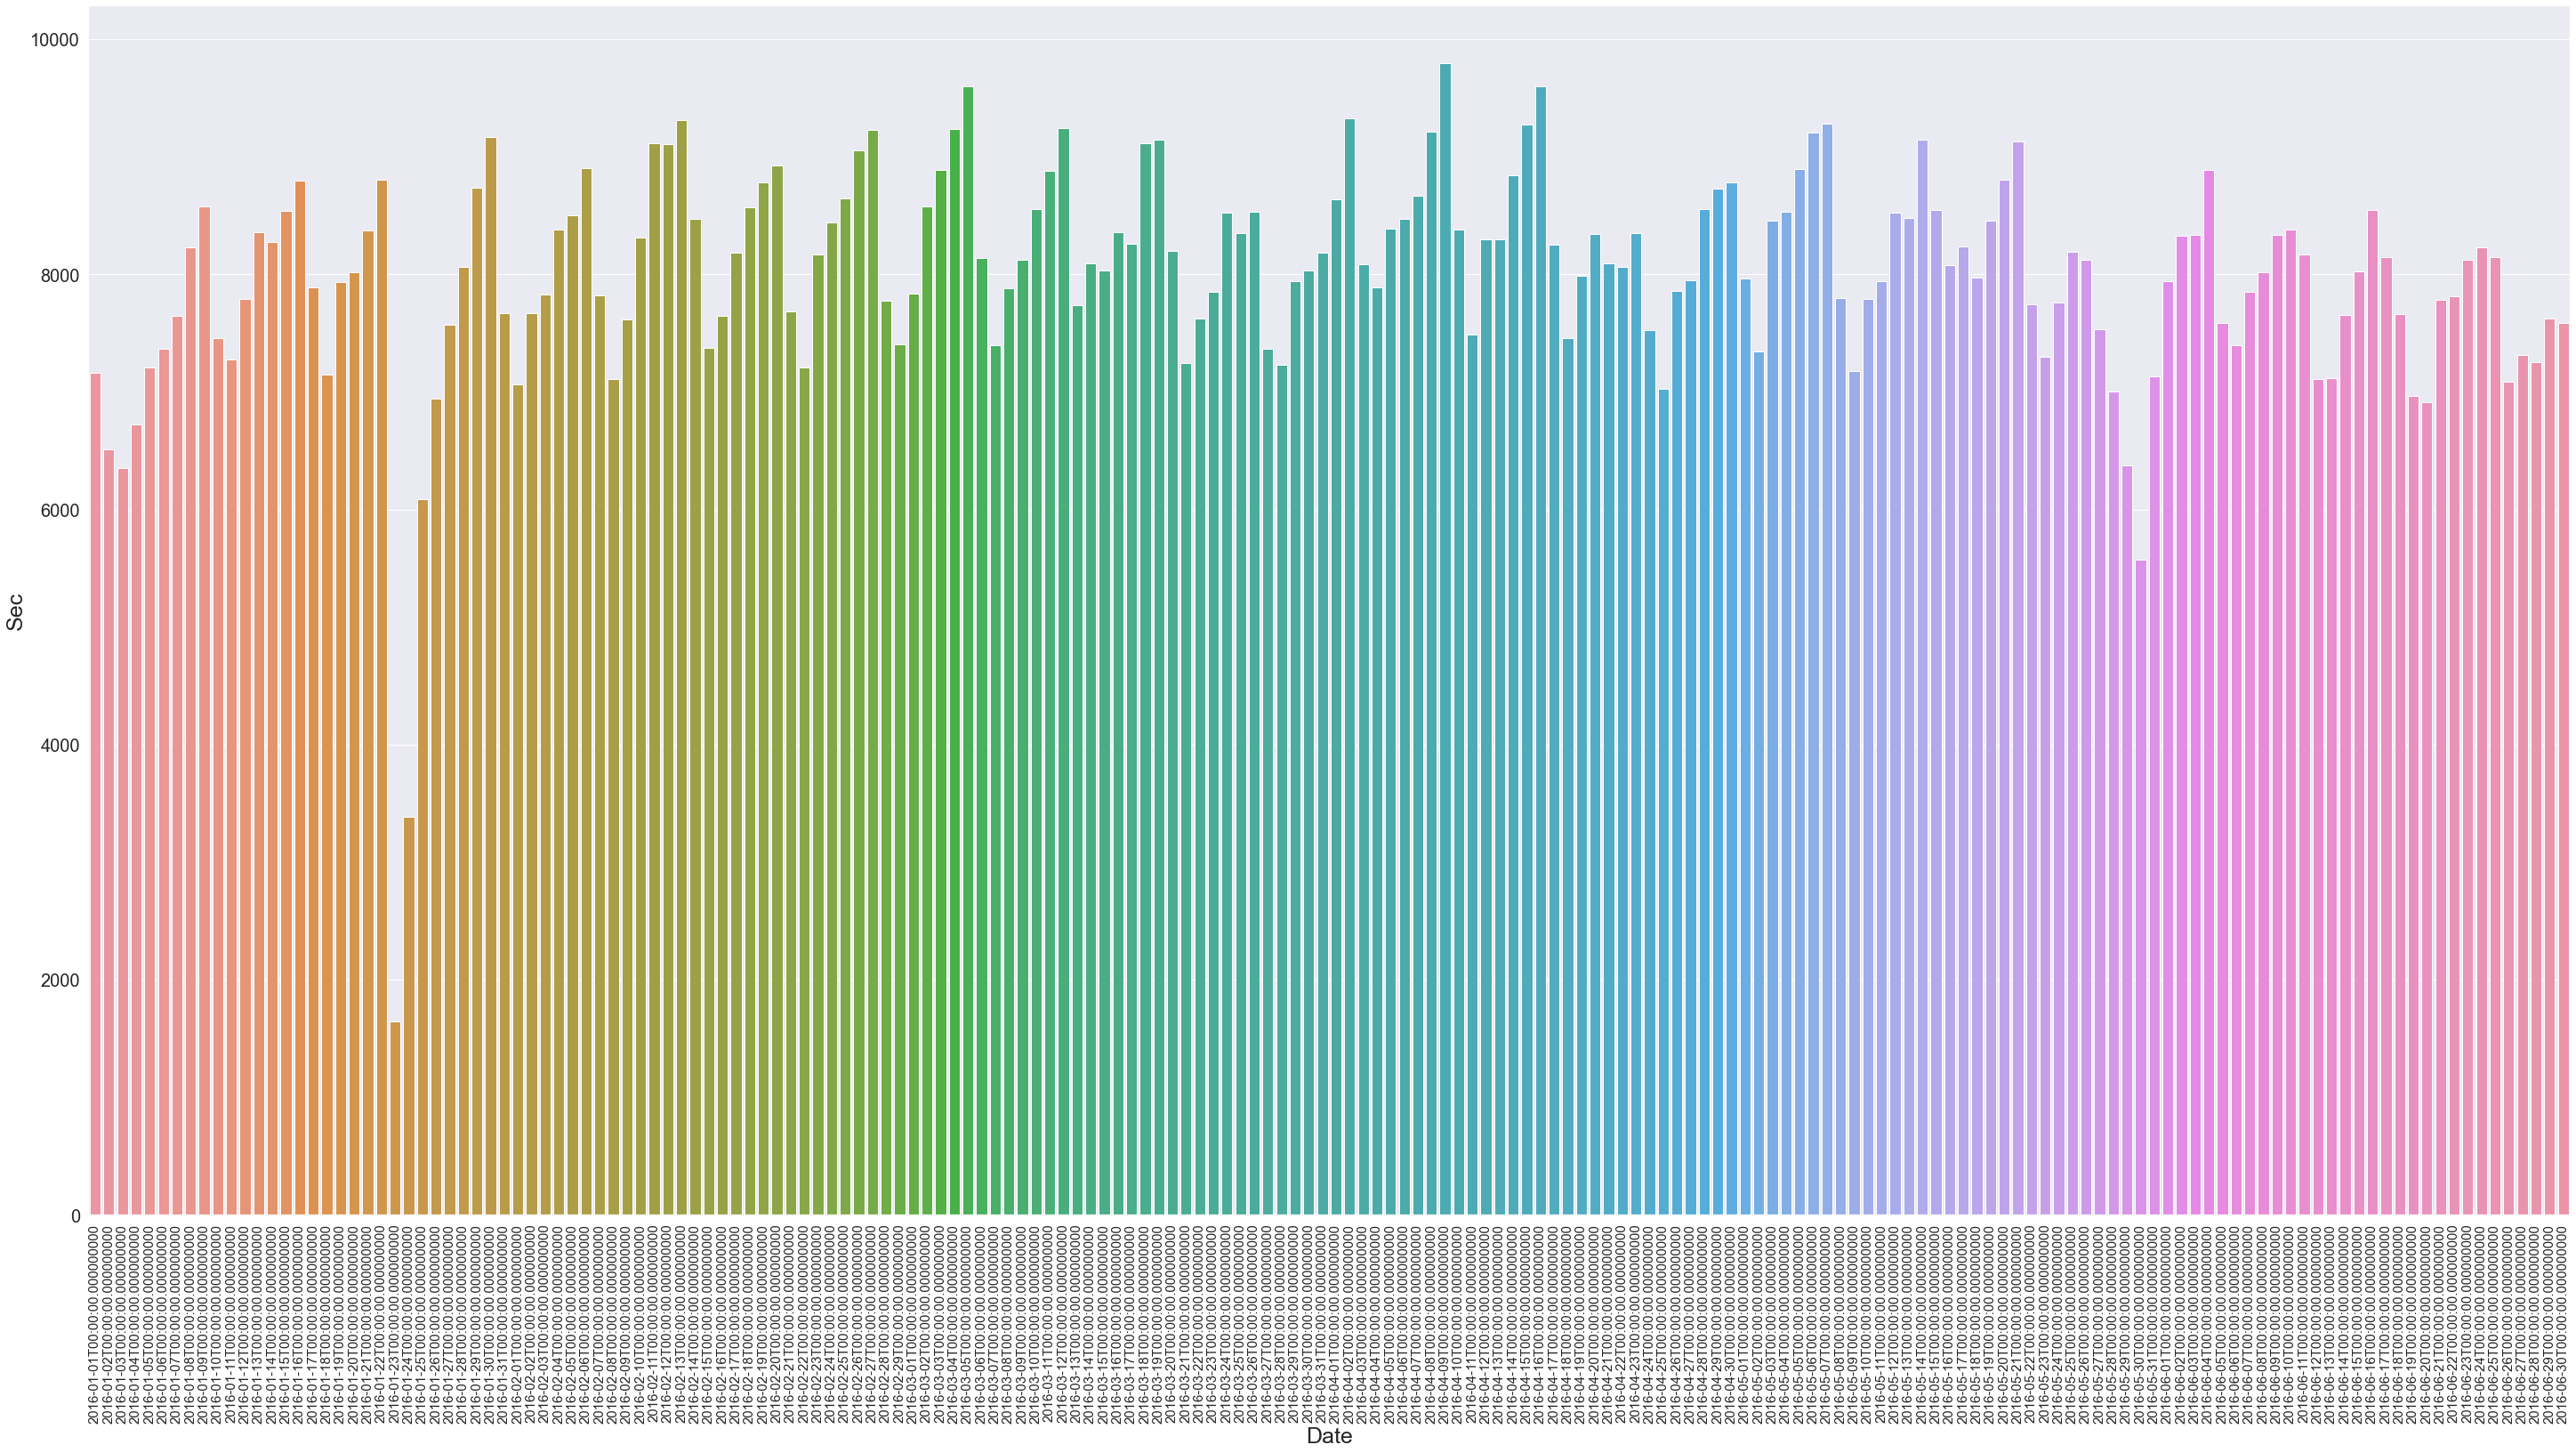

In [25]:
plt.figure(figsize=(50, 25))
ax = sns.countplot(x = 'Date', data = train) 
plt.xlabel('Date', size = 25)
plt.xticks(rotation = 'vertical', size = 15)
plt.yticks(size = 20)
plt.ylabel('Sec', size = 25)

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

В первом случае - это снегопад 23 - 25.1.2016 и 30.05.16 - это Memorial Day

In [26]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], errors='coerce')
train.sample()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Date,Time,log1p_trip_duration
612368,id0137966,2,2016-01-22 08:35:43,1,-73.960037,40.773247,-73.976494,40.75032,N,1039,2016-01-22,08:35:43,6.946976


In [27]:
train['dayofweek']=train['pickup_datetime'].apply(lambda x: calendar.day_name[x.weekday()])
train.sample()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Date,Time,log1p_trip_duration,dayofweek
1252483,id2039085,2,2016-05-16 16:19:09,1,-73.862617,40.768822,-73.96994,40.756882,N,1934,2016-05-16,16:19:09,7.567863,Monday


In [28]:
train['Hours'] = train['pickup_datetime'].dt.hour

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

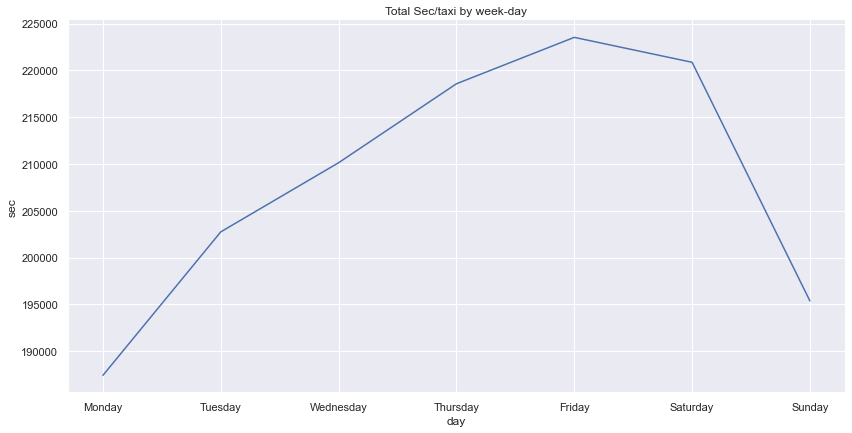

In [29]:
# графики зависимости количества поездок от дня недели и от часов в сутках
dayofweek = train.dayofweek.value_counts().to_frame()
dayofweek = dayofweek.reset_index()
dayofweek= dayofweek.rename(columns={"index":"dayofweek2"})
dayofweek= dayofweek.rename(columns={"dayofweek":"sec"})
dayofweek= dayofweek.rename(columns={"dayofweek2":"day"})
sorter = {223533:5,220868:6,218574:4,210136:3,202749:2,195366:7,187418:1}
dayofweek['Day_id']= dayofweek['sec'].map(sorter)
dayofweek = dayofweek.sort_values(by = ['Day_id'])
sns.relplot(data = dayofweek, x = 'day', y = 'sec',kind="line",height=6,aspect=2).set(title='Total Sec/taxi by week-day')

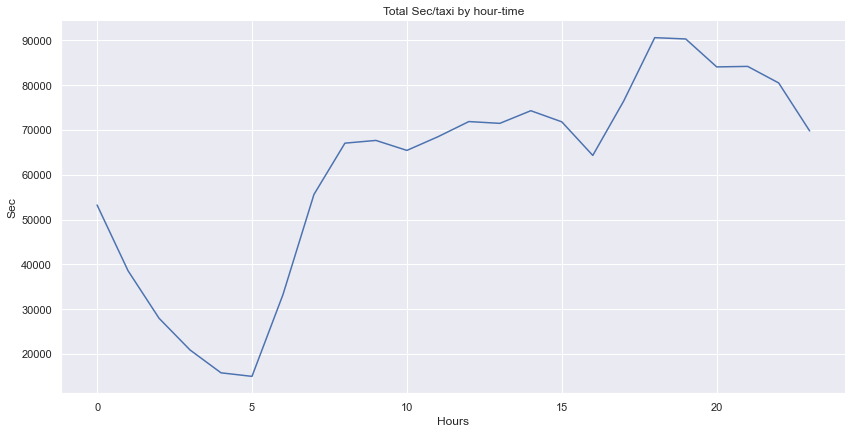

In [30]:
hours = train.Hours.value_counts().to_frame()
hours = hours.reset_index()
hours = hours.rename(columns = {'index':'H'})
hours = hours.rename(columns = {'Hours':'Sec'})
hours = hours.rename(columns = {'H':'Hours'})
hours = hours.sort_values(by =['Hours'])
sns.relplot(data = hours, x = 'Hours', y = 'Sec',kind="line",height=6,aspect=2).set(title='Total Sec/taxi by hour-time')

/var/folders/ct/dgd1v_955fs_m7mc3smd8_140000gn/T/ipykernel_27397/1392958464.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  more_1hour_dur['trip_duration_in_hour']=more_1hour_dur['trip_duration'].apply(lambda x: x//3600)
/var/folders/ct/dgd1v_955fs_m7mc3smd8_140000gn/T/ipykernel_27397/1392958464.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  more_1hour_dur['month'] = pd.DatetimeIndex(more_1hour_dur['Date']).month


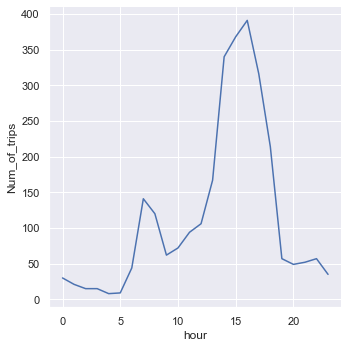

In [31]:
more_1hour_dur = train[train.trip_duration >= 1 * 3600]
more_1hour_dur['trip_duration_in_hour']=more_1hour_dur['trip_duration'].apply(lambda x: x//3600) 
more_1hour_dur['month'] = pd.DatetimeIndex(more_1hour_dur['Date']).month
more_1hour_dur.month.value_counts()
filt_1 = (more_1hour_dur.month == 1)
month_N_1 = more_1hour_dur[filt_1]
month_N_1_num = month_N_1.Hours.value_counts()
filt_2 = (more_1hour_dur.month == 2)
month_N_2 = more_1hour_dur[filt_2]
month_N_2_num = month_N_2.Hours.value_counts()
filt_3 = (more_1hour_dur.month == 3)
month_N_3 = more_1hour_dur[filt_3]
month_N_3_num = month_N_3.Hours.value_counts()
filt_4 = (more_1hour_dur.month == 4)
month_N_4 = more_1hour_dur[filt_2]
month_N_4_num = month_N_4.Hours.value_counts()
filt_5 = (more_1hour_dur.month == 5)
month_N_5 = more_1hour_dur[filt_5]
month_N_5_num = month_N_5.Hours.value_counts()
filt_6 = (more_1hour_dur.month == 6)
month_N_6 = more_1hour_dur[filt_6]
month_N_6_num = month_N_6.Hours.value_counts()
month_N_1_num=month_N_1_num.reset_index()
month_N_2_num=month_N_2_num.reset_index()
month_N_3_num=month_N_3_num.reset_index()
month_N_4_num=month_N_4_num.reset_index()
month_N_5_num=month_N_5_num.reset_index()
month_N_6_num=month_N_6_num.reset_index()
dict = {'index':'hour','Hours':'Num_of_trips'}
month_N_1_num.rename(columns = dict, inplace = 1)
month_N_2_num.rename(columns = dict, inplace = 1)
month_N_3_num.rename(columns = dict, inplace = 1)
month_N_4_num.rename(columns = dict, inplace = 1)
month_N_5_num.rename(columns = dict, inplace = 1)
month_N_6_num.rename(columns = dict, inplace = 1)
month_N_1_num = month_N_1_num.sort_values(by='hour', ascending=1, na_position='first')
month_N_2_num = month_N_2_num.sort_values(by='hour', ascending=1, na_position='first')
month_N_3_num = month_N_3_num.sort_values(by='hour', ascending=1, na_position='first')
month_N_4_num = month_N_4_num.sort_values(by='hour', ascending=1, na_position='first')
month_N_5_num = month_N_5_num.sort_values(by='hour', ascending=1, na_position='first')
month_N_6_num = month_N_6_num.sort_values(by='hour', ascending=1, na_position='first')
month_N_1_num['Month'] = 1
month_N_2_num['Month'] = 2
month_N_3_num['Month'] = 3
month_N_4_num['Month'] = 4
month_N_5_num['Month'] = 5
month_N_6_num['Month'] = 6
sns.relplot(data = month_N_6_num,x ='hour', y ='Num_of_trips',kind = 'line')

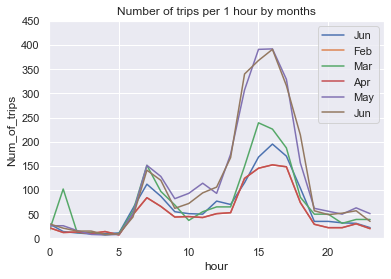

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
for frame in [month_N_1_num, month_N_2_num, month_N_3_num, month_N_4_num, month_N_5_num,month_N_6_num]:
     plt.plot(frame['hour'], frame['Num_of_trips'])
plt.xlabel('hour')
plt.ylabel('Num_of_trips')
plt.title('Number of trips per 1 hour by months')
ax.legend(['Jun','Feb','Mar', 'Apr','May','Jun','Jul'])
plt.xlim(0,24)
plt.ylim(0,450)
plt.show()

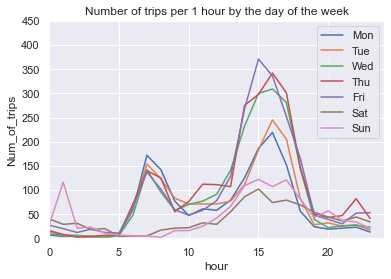

In [33]:
more_1hour_dur_WD = more_1hour_dur.dayofweek.value_counts()
more_1hour_dur_WD = more_1hour_dur_WD.reset_index()
sorter = {1562:1,1705:2,2159:3,2456:4,2389:5,950:6,1113:7}
more_1hour_dur_WD['Day_id'] = more_1hour_dur_WD['dayofweek'].map(sorter)
more_1hour_dur_WD = more_1hour_dur_WD.sort_values(by = ['Day_id'])
more_1hour_dur_WD
filt_1 = (more_1hour_dur.dayofweek == 'Monday')
dayofweek_1 = more_1hour_dur[filt_1]
dayofweek_1_num = dayofweek_1.Hours.value_counts()
filt_2 = (more_1hour_dur.dayofweek == 'Tuesday')
dayofweek_2 = more_1hour_dur[filt_2]
dayofweek_2_num = dayofweek_2.Hours.value_counts()
filt_3 = (more_1hour_dur.dayofweek == 'Wednesday')
dayofweek_3 = more_1hour_dur[filt_3]
dayofweek_3_num = dayofweek_3.Hours.value_counts()
filt_4 = (more_1hour_dur.dayofweek == 'Thursday')
dayofweek_4 = more_1hour_dur[filt_4]
dayofweek_4_num = dayofweek_4.Hours.value_counts()
filt_5 = (more_1hour_dur.dayofweek == 'Friday')
dayofweek_5 = more_1hour_dur[filt_5]
dayofweek_5_num = dayofweek_5.Hours.value_counts()
filt_6 = (more_1hour_dur.dayofweek == 'Saturday')
dayofweek_6 = more_1hour_dur[filt_6]
dayofweek_6_num = dayofweek_6.Hours.value_counts()
filt_7 = (more_1hour_dur.dayofweek == 'Sunday')
dayofweek_7 = more_1hour_dur[filt_7]
dayofweek_7_num = dayofweek_7.Hours.value_counts()

dayofweek_1_num=dayofweek_1_num.reset_index() # Mon
dayofweek_2_num=dayofweek_2_num.reset_index()
dayofweek_3_num=dayofweek_3_num.reset_index()
dayofweek_4_num=dayofweek_4_num.reset_index() # Th
dayofweek_5_num=dayofweek_5_num.reset_index() # Fri
dayofweek_6_num=dayofweek_6_num.reset_index() # Sat
dayofweek_7_num=dayofweek_7_num.reset_index() # Sun

dict = {'index':'hour','Hours':'Num_of_trips'}
dayofweek_1_num.rename(columns = dict, inplace = 1)
dayofweek_2_num.rename(columns = dict, inplace = 1)
dayofweek_3_num.rename(columns = dict, inplace = 1)
dayofweek_4_num.rename(columns = dict, inplace = 1)
dayofweek_5_num.rename(columns = dict, inplace = 1)
dayofweek_6_num.rename(columns = dict, inplace = 1)
dayofweek_7_num.rename(columns = dict, inplace = 1)

dayofweek_1_num = dayofweek_1_num.sort_values(by='hour', ascending=1, na_position='first')
dayofweek_2_num = dayofweek_2_num.sort_values(by='hour', ascending=1, na_position='first')
dayofweek_3_num = dayofweek_3_num.sort_values(by='hour', ascending=1, na_position='first')
dayofweek_4_num = dayofweek_4_num.sort_values(by='hour', ascending=1, na_position='first')
dayofweek_5_num = dayofweek_5_num.sort_values(by='hour', ascending=1, na_position='first')
dayofweek_6_num = dayofweek_6_num.sort_values(by='hour', ascending=1, na_position='first')
dayofweek_7_num = dayofweek_7_num.sort_values(by='hour', ascending=1, na_position='first')

dayofweek_1_num['day'] = 1
dayofweek_2_num['day'] = 2
dayofweek_3_num['day'] = 3
dayofweek_4_num['day'] = 4
dayofweek_5_num['day'] = 5
dayofweek_6_num['day'] = 6
dayofweek_7_num['day'] = 7
fig = plt.figure()
ax = fig.add_subplot(111)
for frame in [dayofweek_1_num, dayofweek_2_num, dayofweek_3_num, dayofweek_4_num, dayofweek_5_num,dayofweek_6_num, 
             dayofweek_7_num]:
     plt.plot(frame['hour'], frame['Num_of_trips'])
plt.xlabel('hour')
plt.ylabel('Num_of_trips')
plt.title('Number of trips per 1 hour by the day of the week')
plt.xlim(0,24)
plt.ylim(0,450)
ax.legend(['Mon','Tue','Wed', 'Thu','Fri','Sat','Sun'])
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

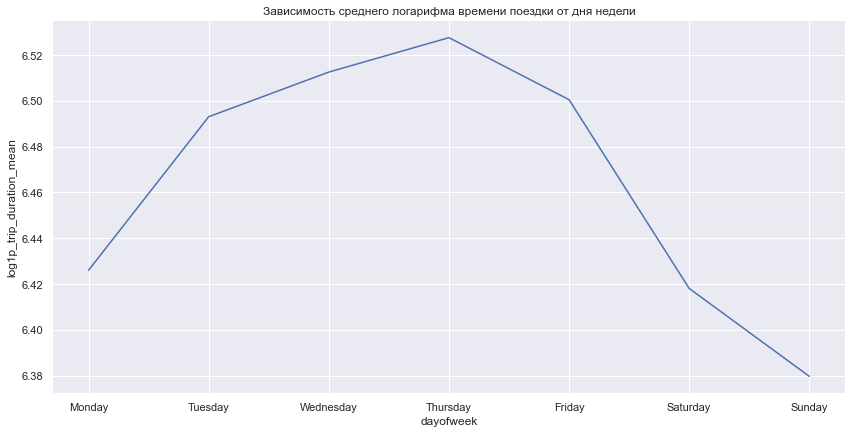

In [34]:
from sklearn.model_selection import train_test_split

y = train["trip_duration"]
X = train.drop(columns=["trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

X_train_dayofweek = X_train.groupby(['dayofweek']).agg({'log1p_trip_duration':[np.mean]})
X_train_dayofweek.columns = [ '_'.join(x) for x in X_train_dayofweek.columns]
X_train_dayofweek = X_train_dayofweek.reset_index()
sorter = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
X_train_dayofweek['Day_id']= X_train_dayofweek['dayofweek'].map(sorter)
X_train_dayofweek = X_train_dayofweek.sort_values(by = ['Day_id'])
X_train_dayofweek
sns.relplot(data = X_train_dayofweek, x = 'dayofweek',
            y = 'log1p_trip_duration_mean',kind="line",height=6,aspect=2).set(title='Зависимость среднего логарифма времени поездки от дня недели')

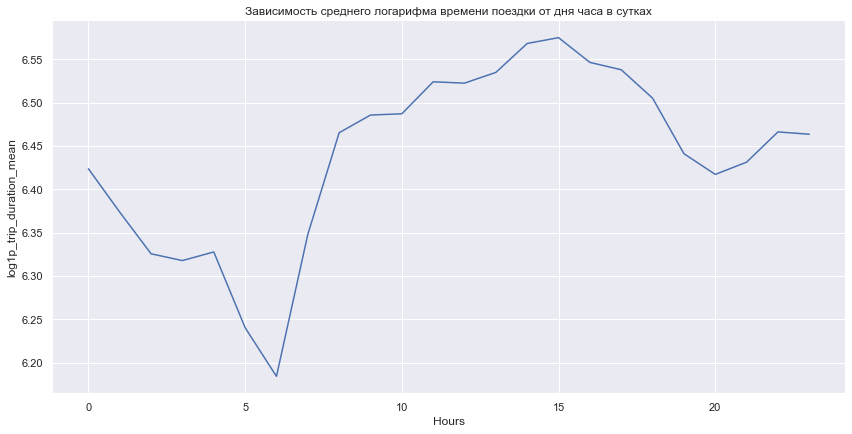

In [35]:
X_train_hours = X_train.groupby(['Hours']).agg({'log1p_trip_duration':[np.mean]})
X_train_hours.columns = [ '_'.join(x) for x in X_train_hours.columns]
X_train_hours = X_train_hours.reset_index()
X_train_hours.sample()
X_train_hours.dtypes
sns.relplot(data = X_train_hours, x = 'Hours',
            y = 'log1p_trip_duration_mean',kind="line",height=6,aspect=2).set(title='Зависимость среднего логарифма времени поездки от дня часа в сутках')

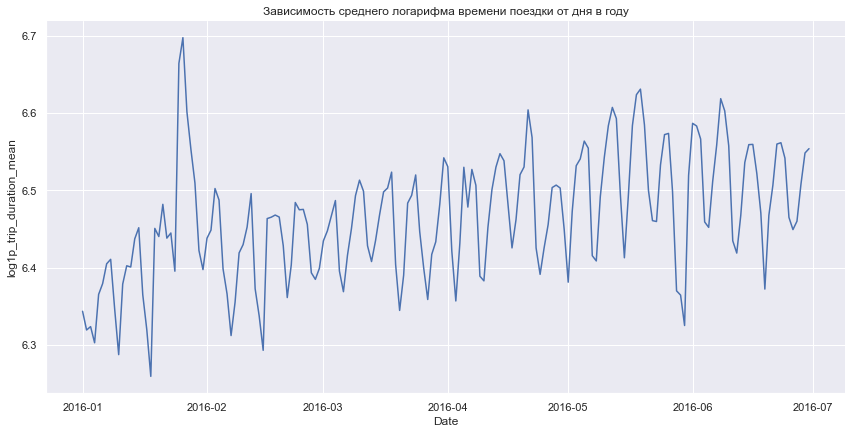

In [36]:
X_train_date = X_train.groupby(['Date']).agg({'log1p_trip_duration':[np.mean]})
X_train_date.columns = [ '_'.join(x) for x in X_train_date.columns]
X_train_date = X_train_date.reset_index()
X_train_date = X_train_date.sort_values(by = 'Date')
X_train_date.sample()
X_train_date['Date_obj'] = pd.to_datetime(X_train_date['Date']).astype(object)
X_train_date = X_train_date.drop(columns = ['Date_obj'])
sns.relplot(data = X_train_date, x = 'Date',
            y = 'log1p_trip_duration_mean',kind="line",height=6,aspect=2).set(title='Зависимость среднего логарифма времени поездки от дня в году')

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [37]:
# Добавьте следующие признаки на основе pickup_datetime:

# День недели
# Месяц
# Час
# Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
# Номер дня в году
train['Month'] = train['Date'].dt.month
train['dayofyear'] = train['Date'].dt.dayofyear
def new_features(train):
    train.loc[:, "is_blizzard"] = train.loc[:, 'pickup_datetime'].dt.date.isin([datetime.date(2016, 1, 23),
                                datetime.date(2016, 1, 24) , datetime.date(2016, 1, 25)])
    def func_year(row):
        return row.strftime("%j")
    train.loc[:, 'yearday'] = train['pickup_datetime'].apply(func_year).astype('int64')
    return train



def add_features(train):
    train.loc[:, "is_memorial_day"] = train.loc[:, 'pickup_datetime'].dt.date == datetime.date(2016, 5, 30)
    def func_year(row):
        return row.strftime("%j")
    train.loc[:, 'yearday'] = train['pickup_datetime'].apply(func_year).astype('int64')
    return train
X_train = add_features(X_train)
X_test = add_features(X_test)
X_train = new_features(X_train)
X_test = new_features(X_test)

/Users/alexanderskovorodko/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/alexanderskovorodko/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [38]:
X_train.is_memorial_day.value_counts()

False    1017176
True        3874
Name: is_memorial_day, dtype: int64

In [39]:
X_train.is_blizzard.value_counts()

False    1013267
True        7783
Name: is_blizzard, dtype: int64

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [40]:
X_test.sample()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,Date,Time,log1p_trip_duration,dayofweek,Hours,is_memorial_day,yearday,is_blizzard
414720,id3047192,2,2016-05-06 07:26:05,1,-73.992989,40.735481,-73.984718,40.76947,N,2016-05-06,07:26:05,6.883463,Friday,7,False,127,False


In [41]:
train.sample()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Date,Time,log1p_trip_duration,dayofweek,Hours,Month,dayofyear
1439222,id3150330,2,2016-06-14 08:06:21,1,-73.983009,40.764416,-73.939522,40.841583,N,1409,2016-06-14,08:06:21,7.251345,Tuesday,8,6,166


In [42]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index) 

X_test_ridge = X_test.drop(['id', 'vendor_id', 'pickup_datetime', 
                              'passenger_count', 'pickup_longitude', 'pickup_latitude',
                              'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'Date', 'Time'], axis = 1)

In [43]:
numeric_data = X_train.select_dtypes([np.number])
numeric_features = numeric_data.columns

In [44]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [45]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Size before OneHot: (1021050, 17)
Size after OneHot: (1021050, 1106912)


In [46]:
print(mean_squared_error(y_pred, y_test))

46824563.28954853


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [47]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [48]:
show_circles_on_map(train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [49]:
show_circles_on_map(train.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

JFK и LaGuardia Airports

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [50]:
! pip3 install haversine

In [51]:
from haversine import haversine, Unit

In [52]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values,
                                                     train['pickup_longitude'].values,
                                                     train['dropoff_latitude'].values,
                                                     train['dropoff_longitude'].values)
# https://github.com/esokolov/ml-course-hse/blob/master/2021-fall/seminars/sem01-pandas.ipynb

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [53]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train['log_haversine'] = train['distance_haversine'].apply(np.log1p)
train

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Date,Time,log1p_trip_duration,dayofweek,Hours,Month,dayofyear,distance_haversine,log_haversine
333752,id0752048,1,2016-01-01 01:11:29,1,-73.963486,40.768528,-73.969521,40.757580,N,274,2016-01-01,01:11:29,5.616771,Friday,1,1,1,1.319222,0.841232
616306,id3056049,1,2016-01-01 13:05:31,1,-73.998032,40.751167,-73.976761,40.751854,N,455,2016-01-01,13:05:31,6.122493,Friday,13,1,1,1.793378,1.027252
1391034,id2365766,1,2016-01-01 15:25:38,1,-74.005302,40.728542,-73.978622,40.764221,N,1070,2016-01-01,15:25:38,6.976348,Friday,15,1,1,4.559729,1.715549
1138825,id3938094,2,2016-01-01 08:37:27,1,-73.977592,40.632847,-73.977592,40.632847,N,413,2016-01-01,08:37:27,6.025866,Friday,8,1,1,0.000000,0.000000
537651,id2777099,2,2016-01-01 12:44:13,2,-73.956978,40.770802,-73.979050,40.785332,N,540,2016-01-01,12:44:13,6.293419,Friday,12,1,1,2.462602,1.242020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061088,id0989838,1,2016-06-30 21:10:48,1,-73.988762,40.745022,-73.998344,40.751926,N,390,2016-06-30,21:10:48,5.968708,Thursday,21,6,182,1.114030,0.748596
1061098,id0776372,1,2016-06-30 18:30:53,1,-73.972488,40.759258,-73.991508,40.697147,N,3077,2016-06-30,18:30:53,8.032035,Thursday,18,6,182,7.089946,2.090622
1253084,id3033214,1,2016-06-30 15:42:12,3,-73.979324,40.766941,-73.971939,40.782211,N,354,2016-06-30,15:42:12,5.872118,Thursday,15,6,182,1.808273,1.032570
1268014,id0845635,2,2016-06-30 00:11:12,1,-74.007706,40.742920,-73.985443,40.768883,N,367,2016-06-30,00:11:12,5.908083,Thursday,0,6,182,3.442481,1.491213


Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

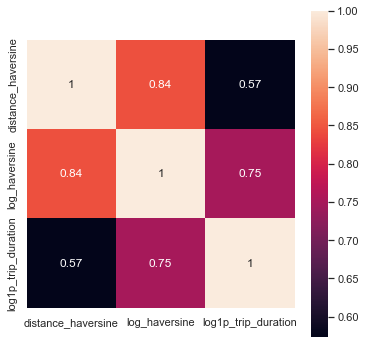

In [54]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
correlat = train[['distance_haversine', 'log_haversine', 'log1p_trip_duration']].corr()
plt.figure(figsize=(6, 6))
sns.heatmap(correlat, square=1,annot=True)
plt.show()
# https://datastart.ru/blog/read/seaborn-heatmaps-13-sposobov-nastroit-vizualizaciyu-matricy-korrelyacii

Да, он коррелирует на уровне .75 , в то время как просто расстояние коррелирует с .57

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [55]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train['Avg_speed'] = train['distance_haversine'] / (train['trip_duration'] / 3600)
train

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Date,Time,log1p_trip_duration,dayofweek,Hours,Month,dayofyear,distance_haversine,log_haversine,Avg_speed
333752,id0752048,1,2016-01-01 01:11:29,1,-73.963486,40.768528,-73.969521,40.757580,N,274,2016-01-01,01:11:29,5.616771,Friday,1,1,1,1.319222,0.841232,17.332850
616306,id3056049,1,2016-01-01 13:05:31,1,-73.998032,40.751167,-73.976761,40.751854,N,455,2016-01-01,13:05:31,6.122493,Friday,13,1,1,1.793378,1.027252,14.189363
1391034,id2365766,1,2016-01-01 15:25:38,1,-74.005302,40.728542,-73.978622,40.764221,N,1070,2016-01-01,15:25:38,6.976348,Friday,15,1,1,4.559729,1.715549,15.341145
1138825,id3938094,2,2016-01-01 08:37:27,1,-73.977592,40.632847,-73.977592,40.632847,N,413,2016-01-01,08:37:27,6.025866,Friday,8,1,1,0.000000,0.000000,0.000000
537651,id2777099,2,2016-01-01 12:44:13,2,-73.956978,40.770802,-73.979050,40.785332,N,540,2016-01-01,12:44:13,6.293419,Friday,12,1,1,2.462602,1.242020,16.417350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061088,id0989838,1,2016-06-30 21:10:48,1,-73.988762,40.745022,-73.998344,40.751926,N,390,2016-06-30,21:10:48,5.968708,Thursday,21,6,182,1.114030,0.748596,10.283352
1061098,id0776372,1,2016-06-30 18:30:53,1,-73.972488,40.759258,-73.991508,40.697147,N,3077,2016-06-30,18:30:53,8.032035,Thursday,18,6,182,7.089946,2.090622,8.295029
1253084,id3033214,1,2016-06-30 15:42:12,3,-73.979324,40.766941,-73.971939,40.782211,N,354,2016-06-30,15:42:12,5.872118,Thursday,15,6,182,1.808273,1.032570,18.389216
1268014,id0845635,2,2016-06-30 00:11:12,1,-74.007706,40.742920,-73.985443,40.768883,N,367,2016-06-30,00:11:12,5.908083,Thursday,0,6,182,3.442481,1.491213,33.768202


In [56]:
Avg_speed = pd.DataFrame(train['Avg_speed'])
Avg_speed

,Avg_speed
333752,17.332850
616306,14.189363
1391034,15.341145
1138825,0.000000
537651,16.417350
...,...
1061088,10.283352
1061098,8.295029
1253084,18.389216
1268014,33.768202


/Users/alexanderskovorodko/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


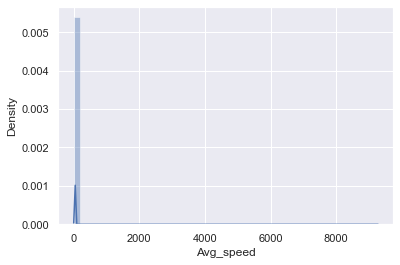

In [57]:
ax = sns.distplot(train['Avg_speed'],label =  'trip_dur')

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

/Users/alexanderskovorodko/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/alexanderskovorodko/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


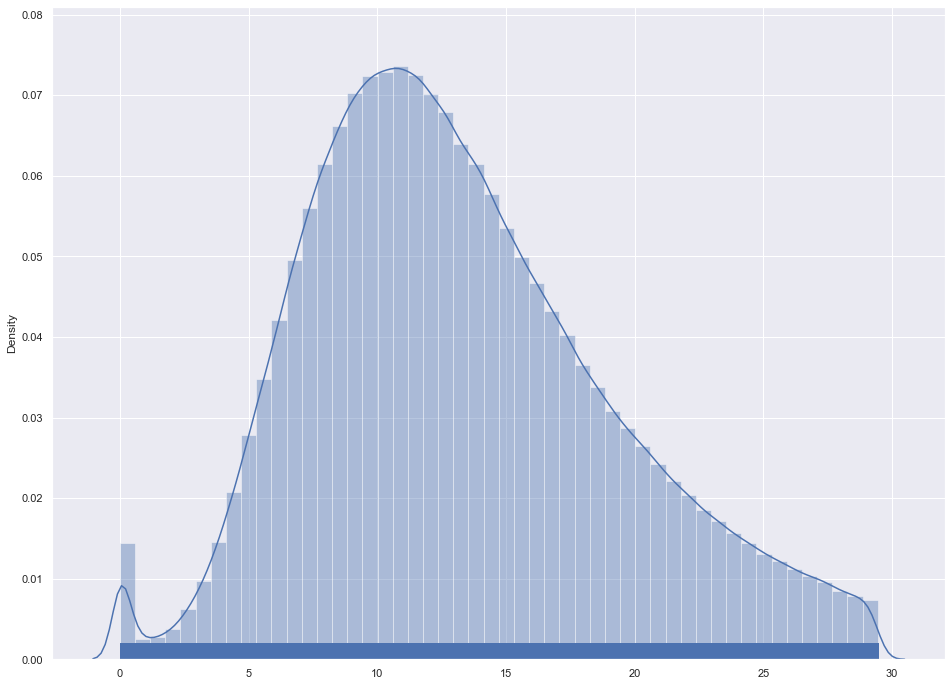

In [58]:
plt.figure(figsize=(16, 12))
ax = sns.distplot(Avg_speed[Avg_speed['Avg_speed'] < Avg_speed['Avg_speed'].quantile(0.95)],rug=True)

Есть выброс около нуля

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [59]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
median_speed_by_dof = train.groupby(['dayofweek', 'Hours'])['Avg_speed'].median()
median_speed_by_dof = pd.DataFrame(median_speed_by_dof).reset_index()
sorter = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
median_speed_by_dof['Day_id'] = median_speed_by_dof['dayofweek'].map(sorter)
median_speed_by_dof = median_speed_by_dof.sort_values(by = ['Day_id','Hours'])
median_speed_by_dof['day_of_week_+_hour'] = median_speed_by_dof['dayofweek'] + "-" +  median_speed_by_dof['Hours'].astype(str)
median_speed_by_dof

,dayofweek,Hours,Avg_speed,Day_id,day_of_week_+_hour
24,Monday,0,20.106301,1,Monday-0
25,Monday,1,20.231745,1,Monday-1
26,Monday,2,20.724691,1,Monday-2
27,Monday,3,20.656916,1,Monday-3
28,Monday,4,23.835226,1,Monday-4
...,...,...,...,...,...
91,Sunday,19,14.061899,7,Sunday-19
92,Sunday,20,15.259830,7,Sunday-20
93,Sunday,21,16.253131,7,Sunday-21
94,Sunday,22,17.235630,7,Sunday-22


In [60]:
median_speed_by_dof = median_speed_by_dof.pivot('Day_id', 'Hours', 'Avg_speed')
median_speed_by_dof

Hours,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Day_id,,,,,,,,,,,,,,,,,,,,,
1,20.106301,20.231745,20.724691,20.656916,23.835226,23.571076,18.889504,14.483844,11.485341,10.789386,...,11.420867,11.520951,11.982454,12.034731,12.134560,13.697765,15.288428,15.887138,16.311531,17.919077
2,18.861346,20.039264,20.419653,21.751292,23.205749,22.805285,18.071393,13.482934,10.390127,9.606393,...,9.881976,9.967234,10.705403,10.926923,10.995780,12.450266,14.074248,14.783644,15.562145,16.694849
3,17.885364,19.448701,20.104192,20.786995,22.812808,22.617380,18.271114,13.472039,10.504677,9.556887,...,9.537208,9.618791,10.478189,10.416376,10.634396,11.802973,13.537860,14.411002,14.872959,16.053941
4,17.301154,19.092758,19.887584,21.056930,22.672957,22.200413,18.380388,13.515849,10.395463,9.699939,...,9.696530,9.774986,10.433259,10.583075,10.570026,11.583827,13.062456,13.567161,13.948482,14.982576
5,16.009300,17.338493,18.110380,18.980297,20.971631,22.691802,18.761231,13.860154,10.793239,9.869755,...,10.571091,10.340931,10.965174,11.092705,11.188064,11.571148,12.676048,12.983389,13.063336,13.387844
6,14.106941,15.523613,16.287046,17.471638,19.077760,22.803637,22.070981,19.565403,17.091156,15.343831,...,12.128966,12.057555,12.282853,12.097564,11.671462,11.243556,12.116525,12.776721,12.728654,13.350243
7,14.304073,15.388534,16.552018,17.594116,18.700540,22.087836,23.833182,21.363506,18.587493,17.344997,...,13.076766,13.169587,13.246462,13.412412,13.410371,14.061899,15.259830,16.253131,17.235630,18.514894


<AxesSubplot:xlabel='Hours', ylabel='Day_id'>

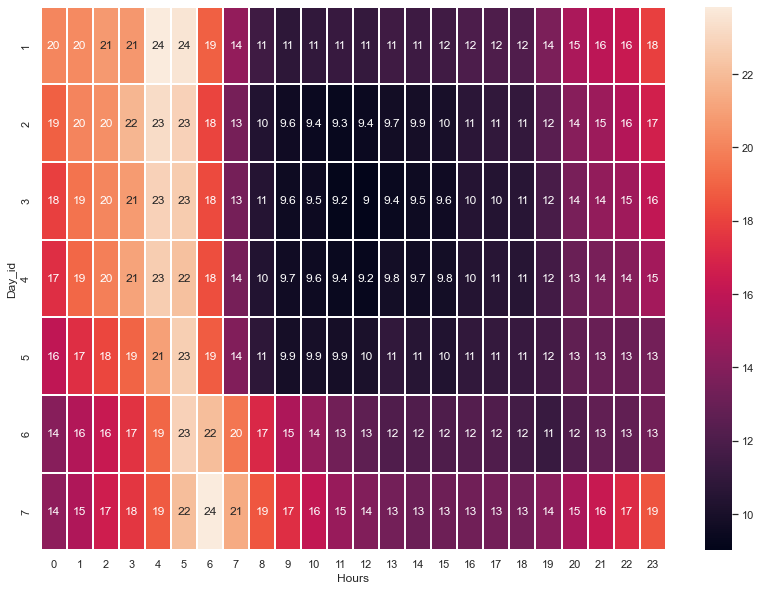

In [61]:
plt.figure(figsize=(14, 10))
sns.heatmap(median_speed_by_dof, linewidths=0.01, annot=True)

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

Причина этому мультиколлинеарность - функциональная зависимость между скоростью и расстоянием и временем. s = t * v 

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

Скорость максимальна в ночное время - сразу после 0 часов. Скорей всего это обуславливается низкой загруженностью трасс. И наоборот - сильная загруженность наблюдается с пон - пт с 8 часов утра и так до 19 часов. 

In [62]:
train.sample()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Date,Time,log1p_trip_duration,dayofweek,Hours,Month,dayofyear,distance_haversine,log_haversine,Avg_speed
350562,id0712964,1,2016-03-23 20:24:56,1,-73.996986,40.723679,-73.995895,40.735252,N,361,2016-03-23,20:24:56,5.891644,Wednesday,20,3,83,1.290226,0.828651,12.866522


In [63]:
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Date,Time,log1p_trip_duration,dayofweek,Hours,Month,dayofyear,distance_haversine,log_haversine,Avg_speed
333752,id0752048,1,2016-01-01 01:11:29,1,-73.963486,40.768528,-73.969521,40.757580,N,274,2016-01-01,01:11:29,5.616771,Friday,1,1,1,1.319222,0.841232,17.332850
616306,id3056049,1,2016-01-01 13:05:31,1,-73.998032,40.751167,-73.976761,40.751854,N,455,2016-01-01,13:05:31,6.122493,Friday,13,1,1,1.793378,1.027252,14.189363
1391034,id2365766,1,2016-01-01 15:25:38,1,-74.005302,40.728542,-73.978622,40.764221,N,1070,2016-01-01,15:25:38,6.976348,Friday,15,1,1,4.559729,1.715549,15.341145
1138825,id3938094,2,2016-01-01 08:37:27,1,-73.977592,40.632847,-73.977592,40.632847,N,413,2016-01-01,08:37:27,6.025866,Friday,8,1,1,0.000000,0.000000,0.000000
537651,id2777099,2,2016-01-01 12:44:13,2,-73.956978,40.770802,-73.979050,40.785332,N,540,2016-01-01,12:44:13,6.293419,Friday,12,1,1,2.462602,1.242020,16.417350


In [64]:
train.dayofweek.value_counts()

Friday       223533
Saturday     220868
Thursday     218574
Wednesday    210136
Tuesday      202749
Sunday       195366
Monday       187418
Name: dayofweek, dtype: int64

In [65]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
def detect_low_traffic_period(row):
    if (row['Hours'] in set([3, 4, 5])) and (row['dayofweek'] in set(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])):
        return True
    elif (row['Hours'] in set([5, 6])) and (row['dayofweek'] in set(['Saturday', 'Sunday'])):
        return True
    else: 
        return False

In [66]:
train['low_traffic_flg'] = train.apply(detect_low_traffic_period, axis=True)

In [67]:
train['low_traffic_flg'].value_counts()

False    1423523
True       35121
Name: low_traffic_flg, dtype: int64

In [68]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
def detect_high_traffic_period(row):
    if (row['Hours'] in set([8,9,10,11,12,13,14,15,16,17,18])) and (row['dayofweek'] in set(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])):
        return True
    elif (row['Hours'] == 19) and (row['dayofweek'] == 'Saturday'):
        return True
    else: 
        return False

In [69]:
train['high_traffic_flg'] = train.apply(detect_high_traffic_period, axis=True)

In [70]:
train['high_traffic_flg'].value_counts()

False    870814
True     587830
Name: high_traffic_flg, dtype: int64

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [71]:
def detect_point_1(row):
    point = (40.77, -73.87)
    delta = 0.01
    if (point[0] - delta < row['pickup_latitude'] < point[0] + delta) and (point[1] - delta < row['pickup_longitude'] < point[1] + delta):
        return True
    else: 
        return False
    
    
def detect_point_2(row):
    point = (40.64 ,-73.77)
    delta = 0.01
    if (point[0] - delta < row['pickup_latitude'] < point[0] + delta) and (point[1] - delta < row['pickup_longitude'] < point[1] + delta):
        return True
    else: 
        return False

In [72]:
train['is_p_1'] = train.apply(detect_point_1, axis=1)

In [73]:
train['is_p_2'] = train.apply(detect_point_2, axis=1)

In [74]:
train['is_p_1'].value_counts()

False    1422981
True       35663
Name: is_p_1, dtype: int64

In [75]:
train['is_p_2'].value_counts()

False    1452199
True        6445
Name: is_p_2, dtype: int64

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

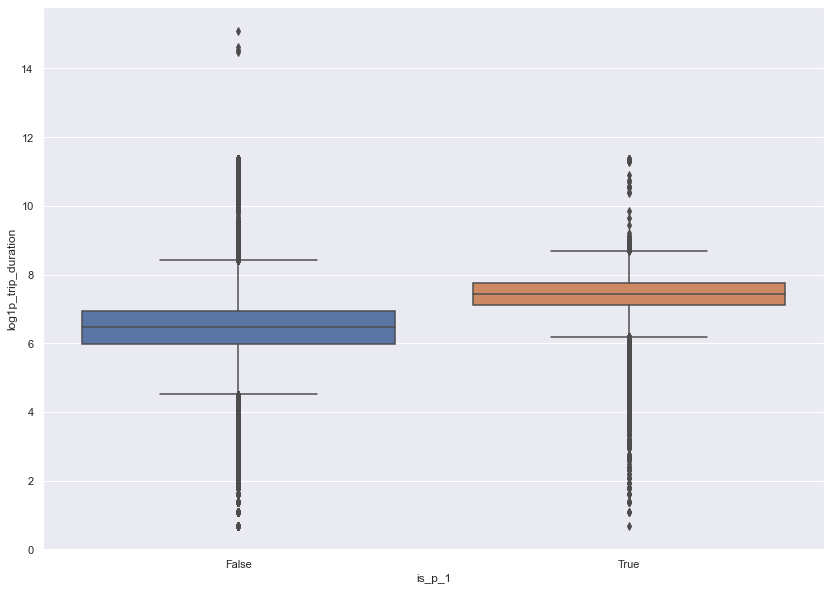

In [76]:
plt.figure(figsize=(14, 10))
sns.boxplot(x = 'is_p_1', y = 'log1p_trip_duration',data=train)
plt.show()

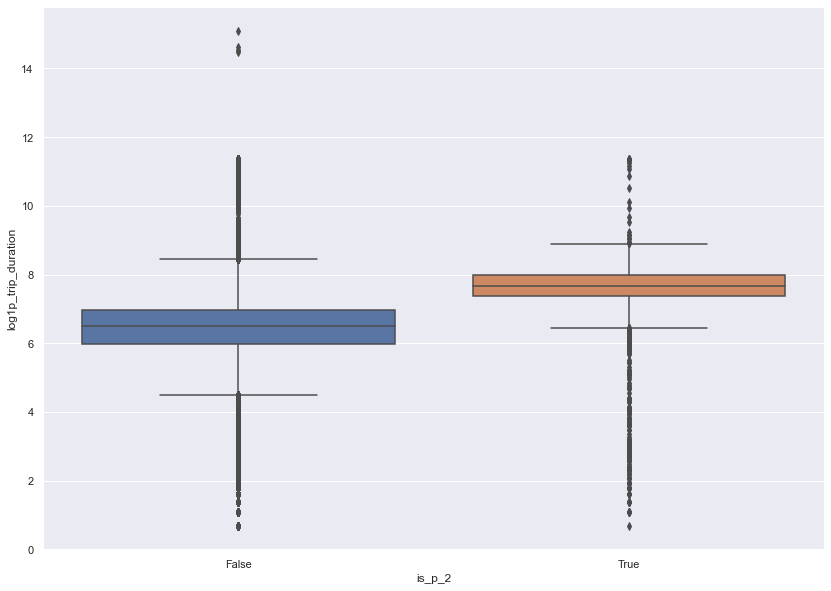

In [77]:
plt.figure(figsize=(14, 10))

sns.boxplot(x = 'is_p_2', y = 'log1p_trip_duration',data=train)
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [79]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [80]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
vendor_id_nuq = train['vendor_id'].nunique()
passenger_count_nuq=train['passenger_count'].nunique()
store_and_fwd_flag_nuq=train['store_and_fwd_flag'].nunique()

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

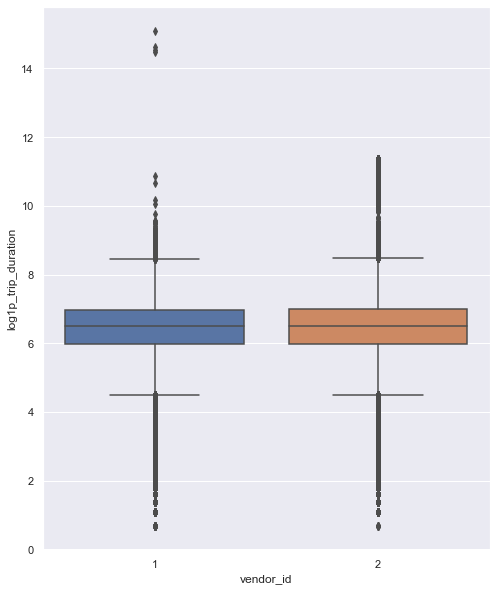

In [81]:
plt.figure(figsize=(8, 10))
a = sns.boxplot(x = 'vendor_id', y = 'log1p_trip_duration',data=train)

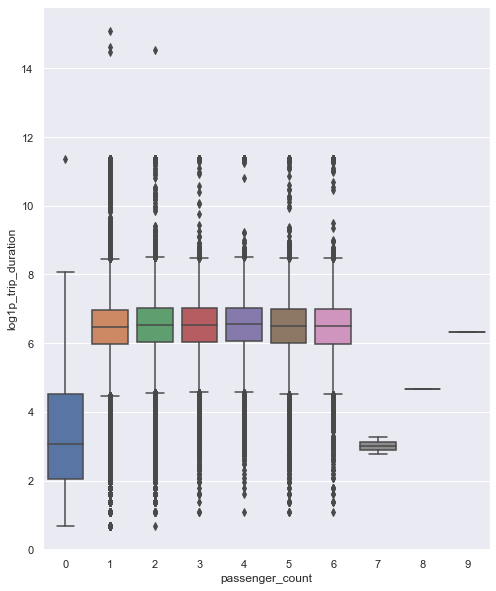

In [82]:
plt.figure(figsize=(8, 10))
b = sns.boxplot(x = 'passenger_count', y = 'log1p_trip_duration',data=train)

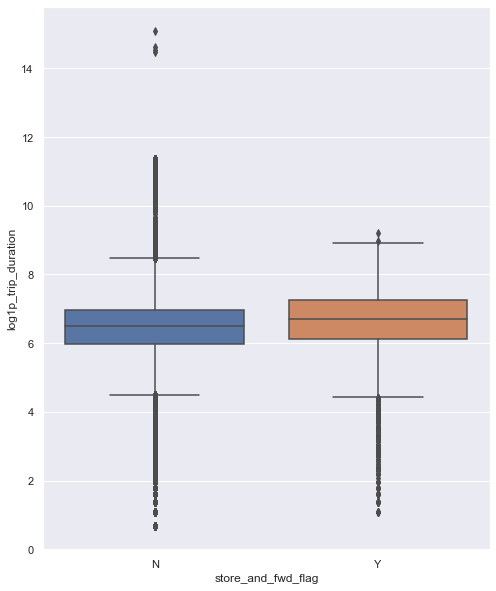

In [83]:
plt.figure(figsize=(8, 10))
c = sns.boxplot(x = 'store_and_fwd_flag',
                y = 'log1p_trip_duration',
                data=train)

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [84]:
train.sample()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,Hours,Month,dayofyear,distance_haversine,log_haversine,Avg_speed,low_traffic_flg,high_traffic_flg,is_p_1,is_p_2
455276,id1144408,1,2016-04-27 19:08:58,1,-73.98156,40.749809,-73.960579,40.772808,N,791,...,19,4,118,3.108469,1.41305,14.147268,False,False,False,False


**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

In [85]:
train = train.replace(to_replace=['N', 'Y'], value=[0, 1])
train = train.replace(to_replace=['1', '2'], value=[0, 1])
train.sample()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,Hours,Month,dayofyear,distance_haversine,log_haversine,Avg_speed,low_traffic_flg,high_traffic_flg,is_p_1,is_p_2
435744,id1398587,2,2016-04-28 06:57:22,2,-73.975967,40.75692,-73.973557,40.761131,0,66,...,6,4,119,0.510419,0.412387,27.841053,False,False,False,False


In [86]:
train.dtypes

id                             object
vendor_id                       int64
pickup_datetime        datetime64[ns]
passenger_count                 int64
pickup_longitude              float64
pickup_latitude               float64
dropoff_longitude             float64
dropoff_latitude              float64
store_and_fwd_flag              int64
trip_duration                   int64
Date                   datetime64[ns]
Time                           object
log1p_trip_duration           float64
dayofweek                      object
Hours                           int64
Month                           int64
dayofyear                       int64
distance_haversine            float64
log_haversine                 float64
Avg_speed                     float64
low_traffic_flg                  bool
high_traffic_flg                 bool
is_p_1                           bool
is_p_2                           bool
dtype: object

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [87]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
log_trip_duration = train['log1p_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(train, log_trip_duration, test_size=0.3, random_state=10)

numeric_data = X_train.select_dtypes([np.number])
numeric_features = numeric_data.columns

categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=0))

Test RMSE = 0.0008


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

Снова построим distplot для log1p_trip_duration для того чтобы определнть выбросы. 

/Users/alexanderskovorodko/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


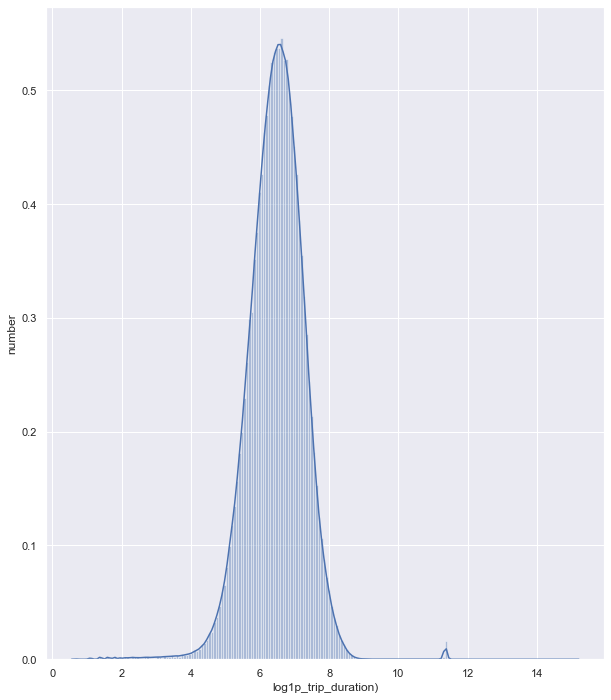

In [88]:
plt.figure(figsize=(10, 12))
sns.distplot(train['log1p_trip_duration'].values, bins=200)
plt.xlabel('log1p_trip_duration)')
plt.ylabel('number')
plt.show()
# https://github.com/esokolov/ml-course-hse/blob/master/2021-fall/seminars/sem01-pandas.ipynb

Исходя из графика видно , что на значениях меньше 2 и на значениях больше 10 присутсвуют выбросы! 

In [89]:
train_more_2 = train[2 < train['log1p_trip_duration'] ]
train_less_10 = train[train['log1p_trip_duration'] > 10]

Сделаем всё тоже самое с log_haversine

/Users/alexanderskovorodko/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


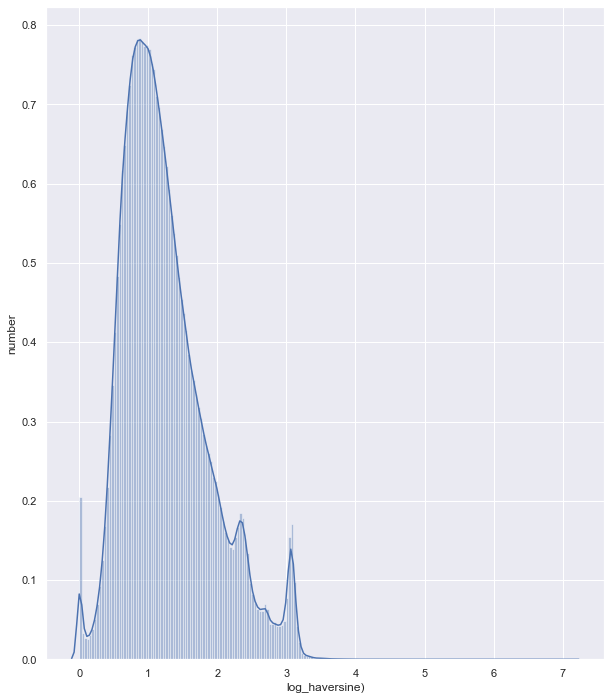

In [90]:
plt.figure(figsize=(10, 12))
sns.distplot(train['log_haversine'].values, bins=200)
plt.xlabel('log_haversine)')
plt.ylabel('number')
plt.show()
# https://github.com/esokolov/ml-course-hse/blob/master/2021-fall/seminars/sem01-pandas.ipynb

Исходя из графика видно , что на значениях больше 3,5 присутсвуют выбросы! На значениях от 2,5 и 3,5 выбросов нет

/Users/alexanderskovorodko/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

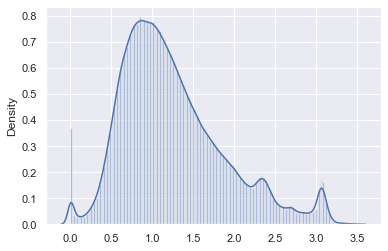

In [91]:
train_more_three_with_half = train[train['log_haversine'] < 3.5]
sns.distplot(train_more_three_with_half['log_haversine'].values, bins=200)

В нашей модели - есть предсказывающая часть , которая есть в задании № 12 

In [92]:
pred_mod_x_test = pd.DataFrame(model.predict(X_test), columns=['log1p_trip_duration'])

In [93]:
pred_mod_x_train = pd.DataFrame(model.predict(X_train), columns=['log1p_trip_duration'])

Так как надо удалить выбросы и из обучения - то просто вычтем из фрейма (model.predict(X_test)) - model.predict(X_train) 

/Users/alexanderskovorodko/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

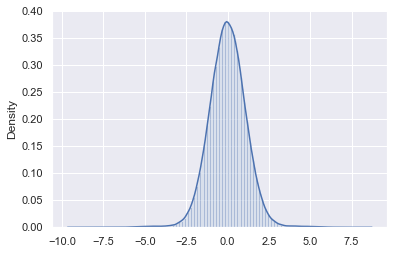

In [94]:
z = pred_mod_x_test - pred_mod_x_train
sns.distplot(z['log1p_trip_duration'].values, bins=200)
# Как мы видим - выбросов нет! 

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [98]:
X_train.sample()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,Hours,Month,dayofyear,distance_haversine,log_haversine,Avg_speed,low_traffic_flg,high_traffic_flg,is_p_1,is_p_2
1166545,id0595633,1,2016-05-21 04:36:13,1,-74.001198,40.741623,-73.98407,40.737556,0,326,...,4,5,142,1.512227,0.92117,16.699442,False,False,False,False


In [101]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
categorical_features = list(X_train.drop(columns=['trip_duration','log1p_trip_duration','distance_haversine', 'log_haversine',
                                                 'Avg_speed', 'pickup_longitude', 'pickup_latitude', 
                                                  'dropoff_longitude',
                                                  'dropoff_latitude']).columns)
categorical_features

['id',
 'vendor_id',
 'pickup_datetime',
 'passenger_count',
 'store_and_fwd_flag',
 'Date',
 'Time',
 'dayofweek',
 'Hours',
 'Month',
 'dayofyear',
 'low_traffic_flg',
 'high_traffic_flg',
 'is_p_1',
 'is_p_2']

In [129]:
vendor_id_tr = X_train['vendor_id'].value_counts()
passenger_count_tr = X_train['passenger_count'].value_counts()
store_and_fwd_flag_tr = X_train['store_and_fwd_flag'].value_counts()
Date_tr = X_train['Date'].value_counts()
Time_tr = X_train['Time'].value_counts()
passenger_count_tr = pd.DataFrame(train['passenger_count'])
passenger_count_tr = passenger_count_tr.reset_index()
passenger_count_tr = passenger_count_tr.sort_values(by = 'passenger_count')
passenger_count_tr

,index,passenger_count
1286597,1122417,0
114568,1265736,0
673897,1025067,0
328760,777319,0
285590,278290,0
...,...,...
1036529,489613,7
917395,824904,7
1276447,433304,7
593,826064,8


/Users/alexanderskovorodko/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


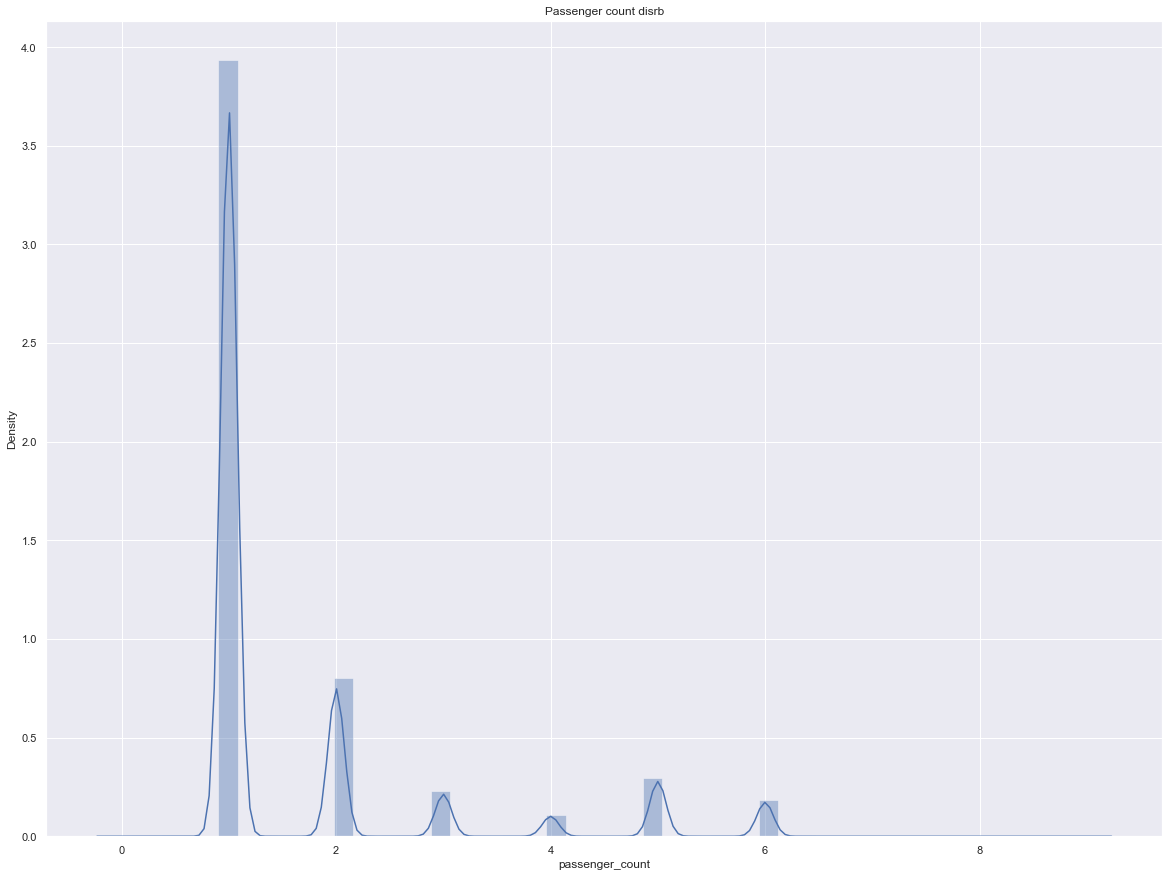

In [128]:
plt.figure(figsize=(20, 15))
sns.distplot(passenger_count_tr['passenger_count'])
plt.title('Passenger count disrb')
plt.show()